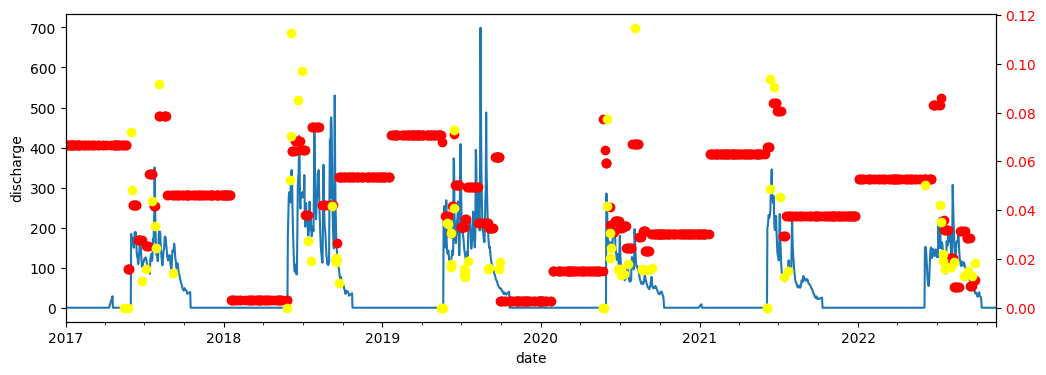

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt
import importlib

# Force reload of project files
import data, train, models, metrics
importlib.reload(data)
from data import get_dataloaders


# Params
feature_labels = ['gage_Q','Blue','Green','Red','Nir','Swir1','Swir2'] #Must be list, even for 1 value
target_label = 'tss'
train_start_date = '2008-01-01'
split_date = '2017-01-01'
num_samples = 10000
sequence_length = 90
batch_size = 1024
num_epochs = 50
hidden_size = 16
feature_size = len(feature_labels)
output_size = 1


df = pd.read_parquet("../data/sag_daily.parquet", engine='pyarrow')
df['gage_Q'] = df['gage_Q'].interpolate(method='linear',limit=7).fillna(0)
df.loc[(df['gage_Q']==0) & (~df['tss'].isna()),'tss'] = 0

# Drop unused data
df = df[feature_labels+[target_label]]

df[feature_labels] = df[feature_labels].interpolate('nearest')

# Drop some of the satellite entries to see how it changes our performance. 
obs_indices = np.where(~df['Red'].isna())[0]
n_obs = len(obs_indices)
obs_indices = np.random.choice(obs_indices, size=int(n_obs*0.6), replace=False)
df.iloc[obs_indices,1:-2] = np.nan

# Split the dataset into training and testing sets based on the fixed date
train_df = df[(df.index > train_start_date) & (df.index < split_date)]
test_df = df[df.index >= split_date]


train_dl, test_dl = get_dataloaders(train_df,
                                    test_df,
                                    features = feature_labels,
                                    target = target_label,
                                    batch_size = batch_size, 
                                    sequence_length = sequence_length,
                                    discharge_col = 'gage_Q',
                                    split_time=True)

plt.figure(figsize=(12, 4))
test_df['gage_Q'].plot()
plt.ylabel('discharge')

ax2 = plt.gca().twinx()
test_df['Nir'].plot(ax=ax2,linestyle='None',marker='o',color='red')
test_df['tss'].plot(ax=ax2,linestyle='None',marker='o',color='yellow')
# ax2.set_ylabel('Nir', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.show()

In [6]:
importlib.reload(models)
importlib.reload(train)
from models import LSTM, MTLSTM 
from train import make_step, lr_dict_scheduler

lr_schedule = { 
    0: 0.01,
    30: 0.005}

# Initialize the model
key = jax.random.PRNGKey(0)
model = MTLSTM(in_size=feature_size,
               out_size=output_size, 
               hidden_size=hidden_size, 
               key=key)

# Initialize optimizer 
current_lr = lr_dict_scheduler(0, lr_schedule)
optim = optax.adam(current_lr)
opt_state = optim.init(model)

# Training loop
loss_list = []
pbar = trange(num_epochs, desc="Epoch")
for epoch in pbar:
    # Update learning rate and optimizer
    current_lr = lr_dict_scheduler(epoch, lr_schedule)
    optim = optax.adam(current_lr)
    
    total_loss = 0
    num_batches = 0
    for data in train_dl:
        loss, model, opt_state = make_step(model, data, opt_state, optim,
                                           loss_name="if_mse",
                                           max_grad_norm=2,
                                           l2_weight = 1E-4)
        total_loss += loss
        num_batches += 1
        if num_batches * batch_size >= num_samples:
            break
            
    current_loss = total_loss / num_batches
    loss_list.append(current_loss)
    pbar.set_postfix_str(f"Loss: {current_loss:.4f}")

plt.plot(loss_list)
plt.ylabel("Loss")
plt.xlabel("Epoch")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)


KeyboardInterrupt: 

In [3]:
# Predict on the test data
predictions = []
ids = []
for data in tqdm(test_dl):
    # Make predictions for the current batch
    pred = jax.vmap(model)(data)
    predictions.extend(pred)
    ids.extend(data['ids'])

# # Convert lists to arrays
predictions = np.array(predictions).flatten()
ids = np.array(ids).flatten()

scale = test_dl.scale
rescaled_pred = predictions * scale['scale'][target_label] + scale['offset'][target_label]

# # Convert lists to arrays
predictions = np.array(predictions).flatten()
ids = np.array(ids).flatten()

rescaled_pred = predictions * scale['scale'][target_label] + scale['offset'][target_label]
test_df['tss_pred'] = np.nan
test_df.iloc[ids,-1] = rescaled_pred

  0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/5d/5xczw7t17xd3m8252wfz_4h40000gq/T/ipykernel_7672/230748314.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['tss_pred'] = np.nan


mse:	0.0004
rmse:	0.0198
kge:	0.4206
nse:	-0.6996


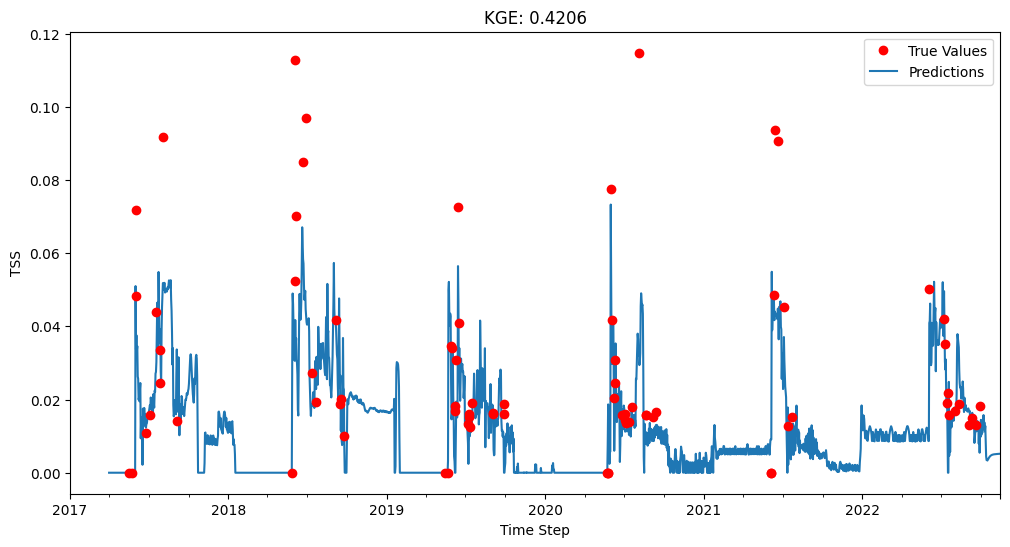

In [4]:
from metrics import get_all_metrics

# Plot the true values and predictions
fig, ax1 = plt.subplots(figsize=(12, 6))
test_df[target_label].plot(ax=ax1,label='True Values',linestyle='none',marker='o',color='red',zorder=10)
ax1.set_ylabel("TSS")
test_df['tss_pred'].plot(ax=ax1,label='Predictions',linestyle='-')

# ax2 = ax1.twinx()
# test_df['gage_Q'].plot(ax=ax2,linestyle='-',alpha=0.5,color='black')
# ax2.set_ylabel("Discharge")

metrics = get_all_metrics(test_df['tss'],test_df['tss_pred'])

for k,v in metrics.items():
    print(f"{k}:\t{v:0.4f}")

plt.xlabel('Time Step')
ax1.legend()
plt.title(f'KGE: {metrics['kge']:0.4f}')
plt.show()

(-0.00573792704395,
 0.12049646792294998,
 -0.0031312070786952972,
 0.12310318788820468)

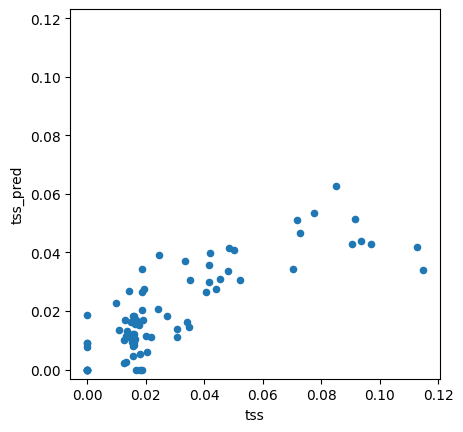

In [5]:
test_df.plot.scatter('tss','tss_pred')
plt.xlim([-0.005,0.12])
plt.ylim([-0.005,0.12])
plt.gca().axis('square')